In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass
from pymarkovchain import MarkovChain
from functions import *
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

### Load data

In [2]:
df = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized.txt')
df_scores = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_data_anonymized.txt')
df["student"] = df["student"].astype('category')
df_scores["student"] = df_scores["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

def remodel_families(row):
    if row["Family"] == "Build" or row["Family"] == "Revise" or row["Family"] == "Extra":
        if row["Outcome"] != "None":
            return "ConstructWithFeedback"
        else:
            return "Construct"
    else:
        return row["Family"]
    
df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)

Here we set up some paramters

In [3]:
ACTIONS_TO_REMOVE = ['I', 'O','S','']

###  Some functions that we use later

In [227]:
def get_markov_chains(df,activity, attribute=None, level=None):
    df2 = df[df.Activity == activity]
    blocks = get_blocks(df2,get_students(),add_spaces = True)
    if attribute:
        blocks = select_blocks(blocks, attribute, level)
    seqs = '.'.join(blocks.values())

    mc = MarkovChain()
    mc.generateDatabase(seqs)
    return mc.db

def make_graph_from_chain(chain_probs):
    edge_labels={}
    G = nx.MultiDiGraph()
    for last_actions,probs in chain_probs.iteritems():
        if len(last_actions) == 1:
            last_action = last_actions[0]
            for next_action,p in probs.iteritems():
                G.add_edge(last_action, next_action, weight = p, label="{:.02f}".format(p))
            edge_labels[(last_action, next_action)] = label="{:.02f}".format(p)
    G.remove_nodes_from(ACTIONS_TO_REMOVE)
    return G

def plot_graph(G, pos = None, reds=False):
    if pos == None:
        pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=700,node_color='#cccccc',alpha=0.8)
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
#     labels = nx.get_edge_attributes(G,'weight')
#     nx.draw_networkx_edge_labels(G,pos,edge_labels={(k[0],k[1]):round(v,3) for k,v in labels.iteritems()})

    cut1 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 20)
    cut2 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 40)
    cut3 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 60)
    cut4 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 80)

    esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= cut1]
    emedium = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut1 and d['weight'] <= cut2]
    elarge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut2 and d['weight'] <= cut3]
    ehuge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut3 and d['weight'] <= cut4]
    enormous = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut4]
    
    colors = ["#c7e9b4","#7fcdbb","#41b6c4","#2c7fb8","#253494"]
    if reds:
        colors = ["#fed976","#feb24c","#fd8d3c","#f03b20","#bd0026"]
        colors = ['#d7191c','#fdae61','#ffffbf','#a6d96a','#1a9641']
    nx.draw_networkx_edges(G,pos,edgelist=esmall,width=3,alpha=1,arros=True,edge_color=colors[0])
    nx.draw_networkx_edges(G,pos,edgelist=emedium,width=3,alpha=1,arros=True,edge_color=colors[1])
    nx.draw_networkx_edges(G,pos,edgelist=elarge,width=3,alpha=1,arros=True,edge_color=colors[2])
    nx.draw_networkx_edges(G,pos,edgelist=ehuge,width=3,alpha=1,arros=True,edge_color=colors[3])
    nx.draw_networkx_edges(G,pos,edgelist=enormous,width=3,alpha=1,arros=True,edge_color=colors[4])
    plt.axis('off')
    return pos

# def plot_graph2(G, pos = None):
#     if pos == None:
#         pos = nx.circular_layout(G)
#     from matplotlib.patches import FancyArrowPatch, Circle

#     def draw_network(G,pos,ax,sg=None):
#         cut1 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 20)
#         cut2 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 40)
#         cut3 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 60)
#         cut4 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 80)

#         esmall = [(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] <= cut1]
#         emedium = [(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] > cut1 and d['weight'] <= cut2]
#         elarge = [(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] > cut2 and d['weight'] <= cut3]
#         ehuge = [(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] > cut3 and d['weight'] <= cut4]
#         enormous = [(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] > cut4]

#         colors = ["#c7e9b4","#7fcdbb","#41b6c4","#2c7fb8","#253494"]
        
#         for n in G:
#             c=Circle(pos[n],radius=10)
# #             ax.add_patch(c)
#             G.node[n]['patch']=c
#             x,y=pos[n]
#         seen={}
#         for edges, color, width in zip([esmall,emedium,elarge,ehuge,enormous],colors,range(5)):
#             for (u,v,d) in edges:
#                 n1=G.node[u]['patch']
#                 n2=G.node[v]['patch']
#                 rad=0.15
#                 if (u,v) in seen:
#                     rad=seen.get((u,v))
#                     rad=(rad+np.sign(rad)*0.1)*-1
#                 alpha=0.7

#                 e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
#                                     arrowstyle='-|>',
#                                     connectionstyle='arc3,rad=%s'%rad,
#                                     mutation_scale=30.0,
#                                     lw=5,
#                                     alpha=alpha,
#                                     color=color)
#                 seen[(u,v)]=rad
#                 ax.add_patch(e)
#         return e

#     nx.draw_networkx_nodes(G,pos,node_size=500,node_color='#cccccc',alpha=0.9)
#     nx.draw_networkx_labels(G,pos,font_size=15,font_family='sans-serif')

#     ax=plt.gca()
#     draw_network(G,pos,ax)
#     ax.autoscale()
#     plt.axis('off')

def make_difference_graph(G1,G2):
    H = nx.MultiDiGraph()
    edges1 = nx.get_edge_attributes(G1,'weight')
    edges2 = nx.get_edge_attributes(G2,'weight')
    for (u,v,d),w1 in edges1.iteritems():
        w2 = edges2[(u,v,d)]
        w = (w1-w2)*2/(w1+w2)
        H.add_edge(u,v, weight = w , label="{:.02f}".format(w))
        print u,v,w1,w2,w
    return H

### Get sequences
Add to the markov chain sentences where each sentence is a student seqence and each word is an action.

In [228]:
chain_probs1_scaff = get_markov_chains(df,'a1','scaffolding','scaff')
chain_probs1_not = get_markov_chains(df,'a1','scaffolding','not')
chain_probs2_scaff = get_markov_chains(df,'a2','scaffolding','scaff')
chain_probs2_not = get_markov_chains(df,'a2','scaffolding','not')

### Create the graph from markov probabilities

In [229]:
G_1_scaff = make_graph_from_chain(chain_probs1_scaff)
G_1_not = make_graph_from_chain(chain_probs1_not)
G_2_scaff = make_graph_from_chain(chain_probs2_scaff)
G_2_not = make_graph_from_chain(chain_probs2_not)

### Visualize!

X C 0.366666666667 0.473684210526 -0.254697286013
T F 0.0443037974684 0.116338751069 -0.896835293721
X P 0.0333333333333 0.0526315789474 -0.448979591837
X T 0.488888888889 0.315789473684 0.43023255814
P X 0.0531914893617 0.0350631136045 0.410819949281
P C 0.0768321513002 0.175315568022 -0.781156514021
T X 0.00791139240506 0.0119760479042 -0.408766079085
C C 0.0169491525424 0.0126718792127 0.288799753163
F T 0.14898989899 0.142401700319 0.0452188648315
C P 0.0162573503978 0.0169857104341 -0.0438202751532
T P 0.417721518987 0.244653550043 0.522567883474
F X 0.00505050505051 0.0047821466525 0.0545851528384
C T 0.0487720511934 0.061202480453 -0.226060144535
F C 0.236531986532 0.252391073326 -0.0648735479928
C F 0.101694915254 0.117821515233 -0.146928409351
F P 0.107744107744 0.116365568544 -0.0769396568929
C X 0.00242130750605 0.00431383122135 -0.56198507318
P T 0.451536643026 0.253856942496 0.560480573078
T C 0.113132911392 0.177929854577 -0.445243780794
P F 0.0508274231678 0.120617110799

{('C', 'C', 0): 0.17704736914790772,
 ('C', 'F', 0): -0.0136201457371488,
 ('C', 'P', 0): -0.382122736038114,
 ('C', 'T', 0): -0.09257137163071102,
 ('C', 'X', 0): 0.809253799047403,
 ('F', 'C', 0): 0.1422671420875766,
 ('F', 'P', 0): -0.27785309207572506,
 ('F', 'T', 0): 0.08615278340916942,
 ('F', 'X', 0): -0.429723783915913,
 ('P', 'C', 0): -0.4178200692041522,
 ('P', 'F', 0): -0.3562593174583988,
 ('P', 'T', 0): 0.34527367257542885,
 ('P', 'X', 0): -0.15473388505048977,
 ('T', 'C', 0): -0.1456133935065927,
 ('T', 'F', 0): 0.10056829251105699,
 ('T', 'P', 0): 0.1850608692668813,
 ('T', 'X', 0): 0.3805855161787364,
 ('X', 'C', 0): 0.4619678995115144,
 ('X', 'P', 0): -0.4680851063829787,
 ('X', 'T', 0): -0.43356643356643354}

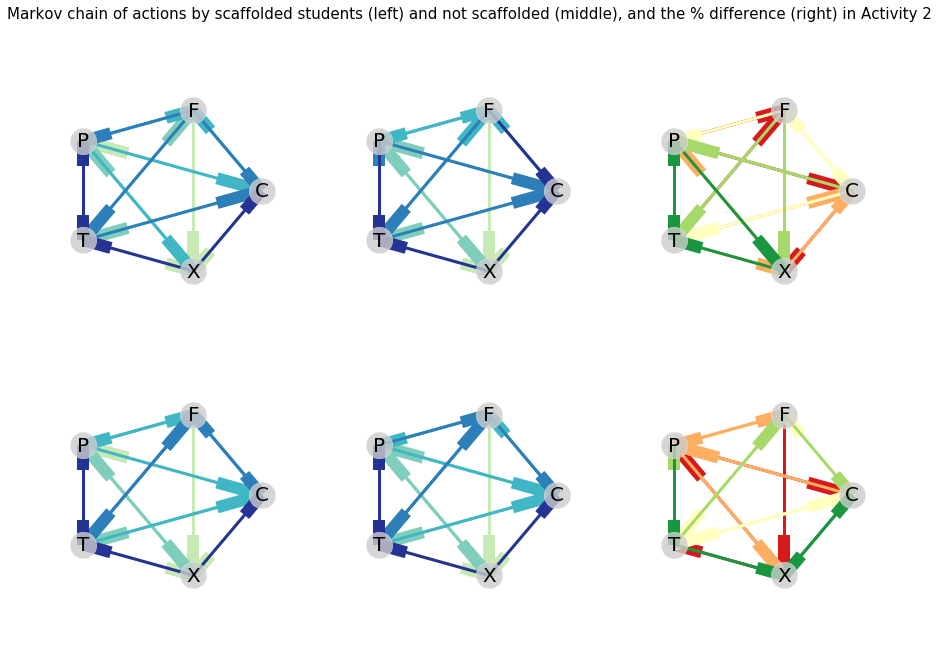

In [231]:
fig = plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
pos = plot_graph(G_1_scaff) #keep the same node position for all graphs
fig.suptitle('Markov chain of actions by scaffolded students (left) and not scaffolded (middle), and the % difference (right) in Activity 1',fontsize=15)
plt.subplot(2, 3, 2)
plot_graph(G_1_not, pos=pos)
plt.subplot(2, 3, 3)
H1 = make_difference_graph(G_1_scaff,G_1_not)
plot_graph(H1, pos=pos, reds=True)
plt.subplot(2, 3, 4)
plot_graph(G_2_scaff, pos=pos)
fig.suptitle('Markov chain of actions by scaffolded students (left) and not scaffolded (middle), and the % difference (right) in Activity 2',fontsize=15)
plt.subplot(2, 3, 5)
plot_graph(G_2_not, pos=pos)
plt.subplot(2, 3, 6)
H2 = make_difference_graph(G_2_scaff,G_2_not)
plot_graph(H2, pos=pos, reds =True)
nx.get_edge_attributes(H2,'weight')

Green means scaffolded students did it more. Red means non scaff did it more.
In activity 1 (graphs in top row) students that were scaffolded tended to:
* Test to Pause and vice versa much more.
* Test then Feedback, Pause then Feedback and Pause then Construct much less.
* Reset after different actions

### Do these differences persist in Activity 2?

Some:
* Scaffolded students still more likely to Pause then Test, and slightly more likely to Test then Pause
* Non scaffolded students still Pause then Construct more.

However,

Scaffolded students are now more likely to Test then Feedback

## Now let's split by learning gains in activity 2
So far, nothing surprising. Let's student actions given learning gains in activity 2.

In [232]:
# chain_probs1_high = get_markov_chains(df,'a1','learning2','high')
# chain_probs1_low = get_markov_chains(df,'a1','learning2','low')
chain_probs2_high = get_markov_chains(df,'a2','learning2','high')
chain_probs2_low = get_markov_chains(df,'a2','learning2','low')

In [233]:
# G_1_high = make_graph_from_chain(chain_probs1_high)
# G_1_low = make_graph_from_chain(chain_probs1_low)
G_2_high = make_graph_from_chain(chain_probs2_high)
G_2_low = make_graph_from_chain(chain_probs2_low)

X C 0.358490566038 0.411764705882 -0.138328530259
T F 0.236399604352 0.210280373832 0.116948293167
X P 0.0754716981132 0.102941176471 -0.307931570762
X T 0.358490566038 0.352941176471 0.015600624025
P X 0.0464071856287 0.0477707006369 -0.0289561607776
P C 0.107784431138 0.124203821656 -0.141553637485
T X 0.00593471810089 0.00841121495327 -0.345254204523
C C 0.0237253912166 0.0194010965837 0.200540078889
F T 0.251194539249 0.215887251762 0.151182461689
C P 0.0196870267542 0.0248840151835 -0.233200221641
T P 0.354104846686 0.294392523364 0.184155945975
F X 0.00273037542662 0.00448430493274 -0.486211285532
C T 0.0555275113579 0.0628426824125 -0.123598193457
F C 0.209556313993 0.265214606022 -0.234463778981
C F 0.158505805149 0.16069169127 -0.0136961357474
F P 0.105119453925 0.0980140935298 0.0699575277856
C X 0.00353356890459 0.0037958667229 -0.0715738104921
P T 0.377245508982 0.31847133758 0.168960035086
T C 0.101879327399 0.127102803738 -0.220309560527
P F 0.172155688623 0.183121019108 

{'C': array([ 1.,  0.]),
 'F': array([ 0.31,  0.95]),
 'P': array([-0.81,  0.59]),
 'T': array([-0.81, -0.59]),
 'X': array([ 0.31, -0.95])}

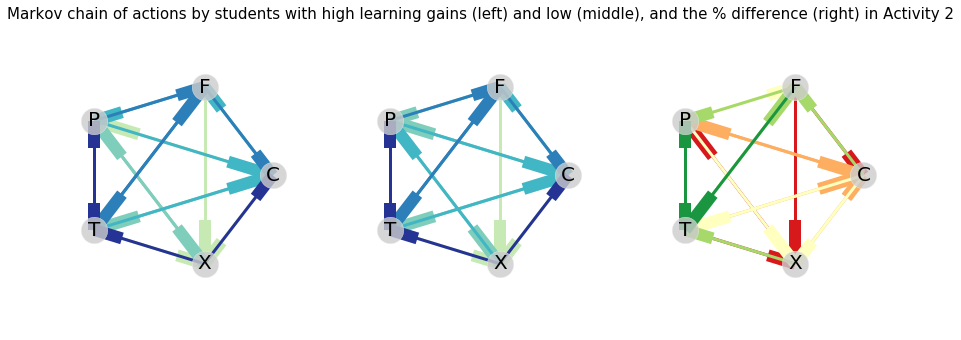

In [234]:
fig = plt.figure(figsize=(15,5))
# plt.subplot(2, 2, 1)
# plot_graph(G_1_high,pos=pos) #keep the same node position for all graphs
# plt.title('Markov chain of actions by students with high learning gains (left) and low (right) in Activity 1')
# plt.subplot(2, 2, 2)
# plot_graph(G_1_low, pos=pos)
plt.subplot(1, 3, 1)
plot_graph(G_2_high, pos=pos)
fig.suptitle('Markov chain of actions by students with high learning gains (left) and low (middle), and the % difference (right) in Activity 2',fontsize=15)
plt.subplot(1, 3, 2)
plot_graph(G_2_low, pos=pos)
plt.subplot(1, 3, 3)
H2 = make_difference_graph(G_2_high,G_2_low)
plot_graph(H2, pos=pos, reds =True)

In activity 2, Students with high learning gains tended to:
* Test then Pause and vice versa more.
* Feedback then Test more
Low learning gains students tend to:
* Feedback then Construct more
* Pause then Construct and vice versa more.